## Library Installation

In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tqdm

from datasets import Dataset, DatasetDict
from flwr_datasets.partitioner import IidPartitioner
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

/home/oksanich/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Processing

In [2]:
label_mapping = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2,
}

In [3]:
training_data = pd.read_csv("data/twitter_training.csv", names=["tweet_id", "entity", "label", "text"])
training_data = training_data[training_data.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
training_data["label"] = training_data["label"].map(label_mapping)
training_ds = Dataset.from_pandas(training_data, preserve_index=False)

validation_data = pd.read_csv("data/twitter_validation.csv", names=["tweet_id", "entity", "label", "text"])
validation_data = validation_data[validation_data.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
validation_data["label"] = validation_data["label"].map(label_mapping)
validation_ds = Dataset.from_pandas(validation_data, preserve_index=False)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

pad = tokenizer.pad_token_id

training_ds = training_ds.map(lambda s, t: {"ids": t(s["text"], truncation=True)["input_ids"]}, fn_kwargs={"t": tokenizer})
validation_ds = validation_ds.map(lambda s, t: {"ids": t(s["text"], truncation=True)["input_ids"]}, fn_kwargs={"t": tokenizer})

training_ds = training_ds.with_format(type="torch", columns=["ids", "label"])
validation_ds = validation_ds.with_format(type="torch", columns=["ids", "label"])

Map: 100%|███████████████████████████| 828/828 [00:00<00:00, 5914.26 examples/s]


In [5]:
DatasetDict({"train": training_ds, "test": validation_ds})

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'ids'],
        num_rows: 61121
    })
    test: Dataset({
        features: ['label', 'text', 'ids'],
        num_rows: 828
    })
})

In [6]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        
        return {
            "ids": batch_ids,
            "label": batch_label
        }
    
    dl = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    
    return dl

training_dl = get_data_loader(training_ds, 32, pad, shuffle=True)
validation_dl = get_data_loader(validation_ds, 32, pad)

## Model Definition

In [7]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes, freeze):
        super().__init__()
        
        self.transformer = transformer
        self.fc = nn.Linear(transformer.config.hidden_size, num_classes)

        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False
                
    def forward(self, ids: torch.Tensor) -> torch.Tensor:
        output = self.transformer(ids, output_attentions=True)
        
        cls_hidden = output.last_hidden_state[:, 0, :]

        prediction = self.fc(torch.tanh(cls_hidden))
        
        return prediction

In [8]:
tf = AutoModel.from_pretrained("bert-base-uncased")

model = Transformer(tf, num_classes=3, freeze=False)

In [ ]:
model.load_state_dict(torch.load("model/trained_model.pth", weights_only=True))

In [9]:
num_parameters = sum(value.numel() for value in model.state_dict().values())

print(f"{num_parameters = }")

num_parameters = 109484547


In [10]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

print(model)

Transformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

## Training and Evaluation

In [11]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    
    return accuracy

def train(net, data_loader, optimizer, crit=criterion):
    net.train()
    
    epoch_losses = []
    epoch_accuracies = []
    
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = net(ids)
        loss = crit(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accuracies)

def test(net, data_loader):
    net.eval()
    
    epoch_losses = []
    epoch_accuracies = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = net(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            
            epoch_losses.append(loss.item())
            epoch_accuracies.append(accuracy.item())
            
    return np.mean(epoch_losses), np.mean(epoch_accuracies)

def run_centralized(
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int,
        learning_rate: float,
        save_checkpoints: bool
):
    losses = []
    accuracies = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        print(f"Training epoch #{epoch + 1}:")
        
        train(model, training_loader, optimizer)

        loss, accuracy = test(model, validation_loader)
        
        losses.append(loss)
        accuracies.append(accuracy)

        print(f"{loss = }")
        print(f"{accuracy = }")
        
        if save_checkpoints:
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss,
                "accuracy": accuracy
            }, "model/checkpoint.pth")
            
    return losses, accuracies

In [12]:
n = 3
lr = 1e-5

l, a = run_centralized(training_dl, validation_dl, epochs=n, learning_rate=lr, save_checkpoints=True)

Training epoch #1:


Evaluating...: 100%|████████████████████████████| 26/26 [00:42<00:00,  1.65s/it]


loss = 0.2969047622038768
accuracy = 0.8916552204352158
Training epoch #2:


Evaluating...: 100%|████████████████████████████| 26/26 [00:42<00:00,  1.65s/it]


loss = 0.11718718200707091
accuracy = 0.9579326923076923
Training epoch #3:


Evaluating...: 100%|████████████████████████████| 26/26 [00:42<00:00,  1.65s/it]


loss = 0.09005720654609971
accuracy = 0.9759615384615384


In [13]:
torch.save(model.state_dict(), "model/trained_model.pth")

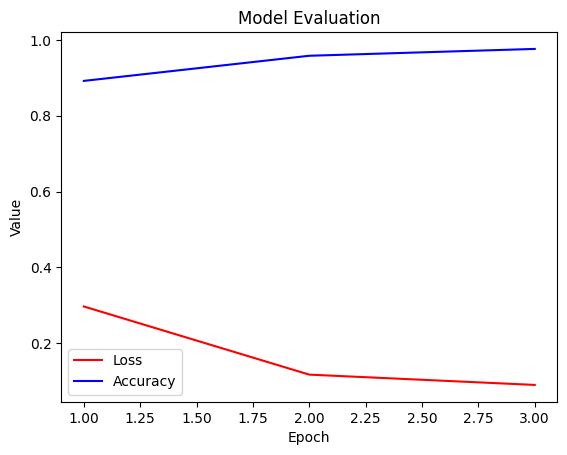

In [14]:
epoch_rng = range(1, n + 1)

plt.plot(epoch_rng, l, label="Loss", color="red")
plt.plot(epoch_rng, a, label="Accuracy", color="blue")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Evaluation")
plt.legend()
plt.show()

## Federated Learning (TODO)

In [ ]:
partitioner = IidPartitioner(num_partitions=10)
partitioner.dataset = training_ds

partitioner.load_partition(partition_id=0)

In [ ]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    max_num_partitions=10,
    title="Label Distribution Per Partition",
)

In [ ]:
from collections import OrderedDict
from typing import Dict, Tuple

from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient

class FlowerClient(NumPyClient):
    def __init__(self, training_loader, validation_loader) -> None:
        super().__init__()

        self.training_loader = training_loader
        self.validation_loader = validation_loader

        self.tf = AutoModel.from_pretrained("bert-base-uncased")
        self.model = Transformer(tf, num_classes=3, freeze=False)

        self.criterion = torch.nn.CrossEntropyLoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = self.model.to(device)
        self.criterion = self.criterion.to(device)

    def fit(self, parameters, config):
        set_params(self.model, parameters)

        optim = torch.optim.Adam(self.model.parameters(), lr=1e-5)

        loss, accuracy = train(self.model, self.training_loader, optim, self.criterion)

        return get_params(self.model), len(self.training_loader), {"loss": loss, "accuracy": accuracy}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_params(self.model, parameters)
        
        loss, accuracy = test(self.model, self.validation_loader)
        
        return float(loss), len(self.validation_loader), {"accuracy": accuracy}

def set_params(ml_model, parameters):
    params_dict = zip(ml_model.state_dict().keys(), parameters)
    
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    
    model.load_state_dict(state_dict, strict=True)

def get_params(ml_model):
    return [val.cpu().numpy() for _, val in ml_model.state_dict().items()]

In [ ]:
from flwr.common import Context
from flwr.client import ClientApp

def client_fn(context: Context):
    partition_id = int(context.node_config["partition-id"])
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)

    trainloader, testloader = get_mnist_dataloaders(partition_train_val, batch_size=32)

    return FlowerClient(training_loader=trainloader, validation_loader=testloader).to_client()

client_app = ClientApp(client_fn=client_fn)

In [ ]:
from typing import List
from flwr.common import Metrics

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}